In [1]:
import lightgbm as lgb
import os
import math
import pandas as pd
import numpy as np
import random
import gc
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder

np.random.seed(2019)
random.seed(2019)
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 280)
pd.set_option('display.max_colwidth', 150)
data_path = '/data/workspace/kimi/tencent_ads/2020/dataset'
preprocess_path = 'preprocess'

In [2]:
user_base_statics_df= pd.read_pickle(f'{preprocess_path}/train_user_base_statics.pkl')
label_df = pd.read_csv(f'{data_path}/train_preliminary/user.csv')
user_base_statics_df = user_base_statics_df.merge(label_df,on='user_id')
user_base_statics_df['click_times_sum_log'] = user_base_statics_df['click_times_sum'].apply(lambda x :math.log(x))
user_base_statics_df['click_times_count_log'] = user_base_statics_df['click_times_count'].apply(lambda x :math.log(x))
user_base_statics_df['age'] = user_base_statics_df['age'] -1
user_base_statics_df = user_base_statics_df.astype(float)
print(user_base_statics_df)


         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
0            1.0             14.0               13.0           12.0                 6.0                       3.0                   12.0               9.0  3.0     1.0             2.639057               2.564949
1            2.0             46.0               45.0           42.0                20.0                       3.0                   36.0              15.0  9.0     1.0             3.828641               3.806662
2            3.0             30.0               30.0           30.0                17.0                       6.0                   28.0               8.0  6.0     2.0             3.401197               3.401197
...          ...              ...                ...            ...                 ...                       ...                    ...               .

In [3]:
train_df = user_base_statics_df[user_base_statics_df.user_id <= 720000]
valid_df = user_base_statics_df[user_base_statics_df.user_id > 720000]
valid_df = valid_df[valid_df.user_id < 2000000]
print(valid_df)


         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  2.0     2.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  1.0     2.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  1.0     1.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...                       ...                    ...               .

In [4]:
def merge_features(train_df,valid_df,train_file,valid_file):
    train_features_df  = pd.read_pickle(f'{preprocess_path}/{train_file}')
    valid_features_df = pd.read_pickle(f'{preprocess_path}/{valid_file}')
    train_df = train_df.merge(train_features_df,on='user_id')
    valid_df = valid_df.merge(valid_features_df,on='user_id')
    print(train_df)
    print(valid_df)
    return train_df,valid_df


In [5]:
train_df,valid_df = merge_features(train_df,valid_df,'industry_top3_l16_train.pkl','industry_top3_l16_valid.pkl')

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log  industry_0  industry_1  industry_2  industry_3  industry_4  \
0            1.0             14.0               13.0           12.0                 6.0                       3.0                   12.0               9.0  3.0     1.0             2.639057               2.564949   -2.407525   -2.480743    0.258189    0.068892    2.275061   
1            2.0             46.0               45.0           42.0                20.0                       3.0                   36.0              15.0  9.0     1.0             3.828641               3.806662    0.528324    0.173733    0.413423   -2.342237    2.927688   
2            3.0             30.0               30.0           30.0                17.0                       6.0                   28.0               8.0  6.0     2.0        

In [6]:
train_df,valid_df = merge_features(train_df,valid_df,'advertiser_id_top3_l32_train.pkl','advertiser_id_top3_l32_valid.pkl')

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log  industry_0  industry_1  industry_2  industry_3  industry_4  \
0            1.0             14.0               13.0           12.0                 6.0                       3.0                   12.0               9.0  3.0     1.0             2.639057               2.564949   -2.407525   -2.480743    0.258189    0.068892    2.275061   
1            2.0             46.0               45.0           42.0                20.0                       3.0                   36.0              15.0  9.0     1.0             3.828641               3.806662    0.528324    0.173733    0.413423   -2.342237    2.927688   
2            3.0             30.0               30.0           30.0                17.0                       6.0                   28.0               8.0  6.0     2.0        

In [7]:
train_df,valid_df = merge_features(train_df,valid_df,'product_id_top3_l32_train.pkl','product_id_top3_l32_valid.pkl')

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log  industry_0  industry_1  industry_2  industry_3  industry_4  \
0            1.0             14.0               13.0           12.0                 6.0                       3.0                   12.0               9.0  3.0     1.0             2.639057               2.564949   -2.407525   -2.480743    0.258189    0.068892    2.275061   
1            2.0             46.0               45.0           42.0                20.0                       3.0                   36.0              15.0  9.0     1.0             3.828641               3.806662    0.528324    0.173733    0.413423   -2.342237    2.927688   
2            3.0             30.0               30.0           30.0                17.0                       6.0                   28.0               8.0  6.0     2.0        

In [8]:
# train_x = train_df.drop(['age','user_id','gender','advertiser_id_seq','industry_seq','product_id_seq'], axis=1)
# train_y = train_df['age'].astype(int)

# valid_x = valid_df.drop(['age','user_id','gender','advertiser_id_seq','industry_seq','product_id_seq'], axis=1)
# valid_y = valid_df['age'].astype(int)

drop_list = ['age','user_id','gender','click_times_sum','click_times_count']
train_x = train_df.drop(drop_list, axis=1)
train_y = train_df['age'].astype(int)

valid_x = valid_df.drop(drop_list, axis=1)
valid_y = valid_df['age'].astype(int)
#print(x)
#print(y)
print(train_x)
print(train_y)

print(valid_x)
print(valid_y)

#train_x,valid_x,train_y,valid_y =  train_test_split(x,y,test_size=0.20, random_state=42)
#print(train_x.shape)
train_data = lgb.Dataset(train_x.values, label=train_y, feature_name=list(train_x.columns),free_raw_data=False)
valid_data = lgb.Dataset(valid_x.values, label=valid_y, feature_name=list(train_x.columns),free_raw_data=False,reference=train_data)



        ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  click_times_sum_log  click_times_count_log  industry_0  industry_1  industry_2  industry_3  industry_4  industry_5  industry_6  industry_7  industry_8  industry_9  \
0                12.0                 6.0                       3.0                   12.0               9.0             2.639057               2.564949   -2.407525   -2.480743    0.258189    0.068892    2.275061    0.609698   -1.124533   -2.170345   -3.801786   -1.069965   
1                42.0                20.0                       3.0                   36.0              15.0             3.828641               3.806662    0.528324    0.173733    0.413423   -2.342237    2.927688    2.095639    4.499999   -2.768379   -0.016797    0.830495   
2                30.0                17.0                       6.0                   28.0               8.0             3.401197               3.401197   -3.704870   -3.90

In [9]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'softmax',
    'num_class':10,
    'metric': 'multi_error',
    'num_leaves': 128,
    'learning_rate': 0.1,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': 1
}
print('Starting training...')
# train

gbm = lgb.train(params,
                train_data,
                 valid_sets=[train_data,valid_data],
                num_boost_round = 2000,
                early_stopping_rounds=100
               )
gbm.save_model('age_emb1.txt')
print('Feature importances:', list(gbm.feature_importance()))

Starting training...
[1]	training's multi_error: 0.774064	valid_1's multi_error: 0.772956
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_error: 0.773083	valid_1's multi_error: 0.77235
[3]	training's multi_error: 0.766906	valid_1's multi_error: 0.767156
[4]	training's multi_error: 0.758188	valid_1's multi_error: 0.759417
[5]	training's multi_error: 0.750074	valid_1's multi_error: 0.752089
[6]	training's multi_error: 0.740554	valid_1's multi_error: 0.744839
[7]	training's multi_error: 0.731781	valid_1's multi_error: 0.737483
[8]	training's multi_error: 0.722861	valid_1's multi_error: 0.73155
[9]	training's multi_error: 0.715676	valid_1's multi_error: 0.725867
[10]	training's multi_error: 0.709142	valid_1's multi_error: 0.721172
[11]	training's multi_error: 0.703083	valid_1's multi_error: 0.716483
[12]	training's multi_error: 0.697282	valid_1's multi_error: 0.71255
[13]	training's multi_error: 0.692274	valid_1's multi_error: 0.709144
[14]	training's mu

[118]	training's multi_error: 0.549343	valid_1's multi_error: 0.66885
[119]	training's multi_error: 0.548414	valid_1's multi_error: 0.668594
[120]	training's multi_error: 0.54751	valid_1's multi_error: 0.668656
[121]	training's multi_error: 0.546726	valid_1's multi_error: 0.668361
[122]	training's multi_error: 0.545769	valid_1's multi_error: 0.6682
[123]	training's multi_error: 0.544894	valid_1's multi_error: 0.668267
[124]	training's multi_error: 0.54404	valid_1's multi_error: 0.668117
[125]	training's multi_error: 0.543139	valid_1's multi_error: 0.668133
[126]	training's multi_error: 0.54209	valid_1's multi_error: 0.6681
[127]	training's multi_error: 0.541024	valid_1's multi_error: 0.668033
[128]	training's multi_error: 0.540031	valid_1's multi_error: 0.667811
[129]	training's multi_error: 0.539167	valid_1's multi_error: 0.667683
[130]	training's multi_error: 0.538308	valid_1's multi_error: 0.667706
[131]	training's multi_error: 0.537379	valid_1's multi_error: 0.667489
[132]	training

[234]	training's multi_error: 0.451503	valid_1's multi_error: 0.664689
[235]	training's multi_error: 0.45079	valid_1's multi_error: 0.664456
[236]	training's multi_error: 0.449978	valid_1's multi_error: 0.664422
[237]	training's multi_error: 0.449199	valid_1's multi_error: 0.6643
[238]	training's multi_error: 0.448382	valid_1's multi_error: 0.664322
[239]	training's multi_error: 0.447476	valid_1's multi_error: 0.664344
[240]	training's multi_error: 0.446758	valid_1's multi_error: 0.664417
[241]	training's multi_error: 0.445999	valid_1's multi_error: 0.664372
[242]	training's multi_error: 0.445249	valid_1's multi_error: 0.66455
[243]	training's multi_error: 0.444481	valid_1's multi_error: 0.66445
[244]	training's multi_error: 0.443719	valid_1's multi_error: 0.664289
[245]	training's multi_error: 0.442975	valid_1's multi_error: 0.664489
[246]	training's multi_error: 0.442299	valid_1's multi_error: 0.664278
[247]	training's multi_error: 0.441497	valid_1's multi_error: 0.664456
[248]	train

[350]	training's multi_error: 0.370744	valid_1's multi_error: 0.663739
[351]	training's multi_error: 0.370192	valid_1's multi_error: 0.663633
[352]	training's multi_error: 0.36949	valid_1's multi_error: 0.6637
[353]	training's multi_error: 0.368847	valid_1's multi_error: 0.663633
[354]	training's multi_error: 0.368192	valid_1's multi_error: 0.663656
[355]	training's multi_error: 0.36754	valid_1's multi_error: 0.663778
[356]	training's multi_error: 0.36685	valid_1's multi_error: 0.663772
[357]	training's multi_error: 0.366362	valid_1's multi_error: 0.663733
[358]	training's multi_error: 0.365797	valid_1's multi_error: 0.663661
[359]	training's multi_error: 0.365178	valid_1's multi_error: 0.663639
[360]	training's multi_error: 0.364565	valid_1's multi_error: 0.663728
[361]	training's multi_error: 0.363903	valid_1's multi_error: 0.663828
[362]	training's multi_error: 0.363386	valid_1's multi_error: 0.66375
[363]	training's multi_error: 0.362806	valid_1's multi_error: 0.663733
[364]	traini

In [10]:
before_one_hot =  train_y.values.reshape([-1,1])
print(before_one_hot)
enc = OneHotEncoder()
enc.fit(before_one_hot)

one_hoted_y  = enc.transform(before_one_hot).toarray()
print(one_hoted_y.shape)


[[3]
 [9]
 [6]
 ...
 [3]
 [3]
 [4]]
(720000, 10)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
gc.collect()
y_pred = gbm.predict(train_x.astype(float))
for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0
                
print(precision_score(one_hoted_y, y_pred,average='micro'))

ret = []
for user_id,age in zip(range(1000000),y_pred):
    ret.append([int(user_id),int(age.tolist().index(1) + 1)])
ret_df = pd.DataFrame(ret,columns=['user_id','predicted_age'])
print(ret_df['predicted_age'].value_counts())

0.6255013888888888
3     238010
2     123271
5      94186
       ...  
1      21185
9      16740
10      9659
Name: predicted_age, Length: 10, dtype: int64


In [12]:

before_one_hot =  valid_y.values.reshape([-1,1])
print(before_one_hot)
enc = OneHotEncoder()
enc.fit(before_one_hot)

one_hoted_y  = enc.transform(before_one_hot).toarray()
print(one_hoted_y.shape)


[[2]
 [1]
 [1]
 ...
 [3]
 [2]
 [2]]
(180000, 10)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [21]:
y_pred = gbm.predict(valid_x.astype(float))
for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0
                
precision_score(one_hoted_y, y_pred,average='micro')


0.3367888888888889

In [22]:
ret = []
for user_id,age,label_age in zip(range(1000000),y_pred,valid_y):
    ret.append([int(user_id + 720001),int(age.tolist().index(1)),label_age])
ret_df = pd.DataFrame(ret,columns=['user_id','predicted_age','label_age'])
print(ret_df)
print(ret_df['predicted_age'].value_counts())

        user_id  predicted_age  label_age
0        720001              2          2
1        720002              2          1
2        720003              1          1
...         ...            ...        ...
179997   899998              2          3
179998   899999              2          2
179999   900000              3          2

[180000 rows x 3 columns]
2    65012
1    30844
4    24809
     ...  
7     3540
8     2798
9     1711
Name: predicted_age, Length: 10, dtype: int64


In [23]:
true_user_df = ret_df[ret_df.predicted_age == ret_df.label_age ]
print(true_user_df)


        user_id  predicted_age  label_age
0        720001              2          2
2        720003              1          1
3        720004              2          2
...         ...            ...        ...
179992   899993              1          1
179996   899997              2          2
179998   899999              2          2

[60622 rows x 3 columns]


In [24]:
true_user_df = true_user_df.merge(user_base_statics_df,on='user_id')
print(true_user_df)

       user_id  predicted_age  label_age  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
0       720001              2          2             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  2.0     2.0             3.465736               3.332205
1       720003              1          1             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  1.0     1.0             3.044522               2.995732
2       720004              2          2             12.0               11.0           11.0                 9.0                       4.0                   11.0               6.0  2.0     1.0             2.484907               2.397895
...        ...            ...        ...              ..

5.0         2
6.0         9
7.0        22
8.0       143
9.0       636
10.0     2292
11.0     2706
12.0     2527
13.0     2431
14.0     2345
15.0     2133
16.0     2004
17.0     1985
18.0     1767
19.0     1765
20.0     1712
21.0     1568
22.0     1495
23.0     1401
24.0     1304
25.0     1289
26.0     1212
27.0     1125
28.0     1112
29.0     1069
30.0      999
31.0      934
32.0      875
33.0      900
34.0      870
35.0      798
36.0      749
37.0      692
38.0      732
39.0      642
40.0      598
41.0      623
42.0      598
43.0      565
44.0      504
45.0      505
46.0      477
47.0      469
48.0      438
49.0      406
50.0      431
51.0      355
52.0      359
53.0      338
54.0      355
         ... 
279.0       2
280.0       3
282.0       2
283.0       1
284.0       2
285.0       1
286.0       3
289.0       1
290.0       3
291.0       1
293.0       1
294.0       1
295.0       2
296.0       1
298.0       2
299.0       2
300.0       1
302.0       1
303.0       1
305.0       2
308.0 

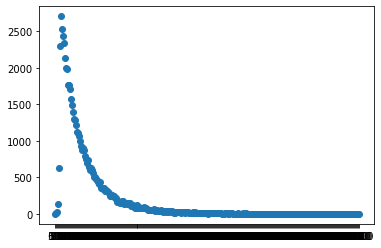

In [25]:
plt_values =  true_user_df['click_times_count'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

10.0     1933
11.0     2729
12.0     2427
13.0     2363
14.0     2293
15.0     2124
16.0     1988
17.0     1906
18.0     1782
19.0     1753
20.0     1652
21.0     1550
22.0     1547
23.0     1415
24.0     1321
25.0     1299
26.0     1190
27.0     1131
28.0     1093
29.0     1054
30.0     1024
31.0      939
32.0      905
33.0      909
34.0      823
35.0      817
36.0      792
37.0      740
38.0      703
39.0      665
40.0      652
41.0      650
42.0      579
43.0      585
44.0      514
45.0      545
46.0      473
47.0      479
48.0      475
49.0      447
50.0      426
51.0      398
52.0      395
53.0      341
54.0      333
55.0      369
56.0      312
57.0      311
58.0      301
59.0      301
         ... 
314.0       2
315.0       1
316.0       1
318.0       2
322.0       1
323.0       1
324.0       1
326.0       1
327.0       1
328.0       1
329.0       1
331.0       1
334.0       1
335.0       4
336.0       1
337.0       2
339.0       1
341.0       1
344.0       1
348.0       1
349.0 

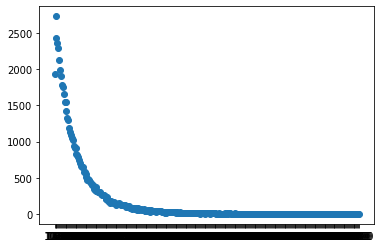

In [26]:
plt_values =  true_user_df['click_times_sum'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

2.0    22266
1.0    15035
4.0     6469
       ...  
7.0      815
9.0      723
8.0      714
Name: age, Length: 10, dtype: int64


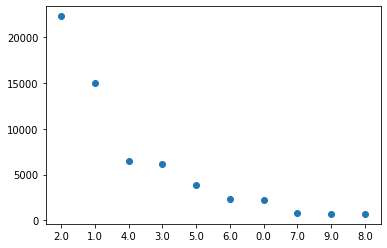

In [27]:
plt_values =  true_user_df['age'].value_counts()
print(plt_values)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

In [30]:
valid_user_base_statics_df =  user_base_statics_df[user_base_statics_df.user_id > 720000]
print(valid_user_base_statics_df)

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  2.0     2.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  1.0     2.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  1.0     1.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...                       ...                    ...               .

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  2.0     2.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  1.0     2.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  1.0     1.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...                       ...                    ...               .

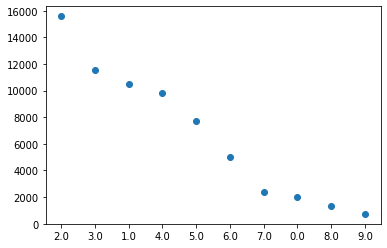

In [31]:
len_10_30_df = valid_user_base_statics_df[valid_user_base_statics_df.click_times_count > 10]
len_10_30_df = len_10_30_df[len_10_30_df.click_times_count <=20]
print(valid_user_base_statics_df)
plt_values =  len_10_30_df['age'].value_counts()
print(plt_values)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

2.0    40771
3.0    30059
1.0    29834
       ...  
7.0     6392
8.0     3856
9.0     2310
Name: age, Length: 10, dtype: int64


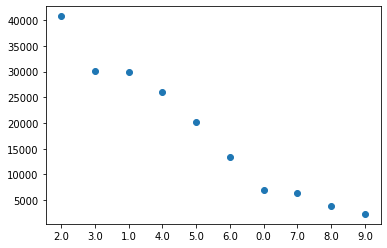

In [32]:

plt_values =  valid_user_base_statics_df['age'].value_counts()
print(plt_values)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

4.0           3
5.0           5
6.0          28
7.0         117
8.0         471
9.0        2080
10.0       7395
11.0       8741
12.0       8128
13.0       7680
14.0       7294
15.0       6769
16.0       6258
17.0       5960
18.0       5539
19.0       5265
20.0       5060
21.0       4629
22.0       4408
23.0       4125
24.0       3957
25.0       3686
26.0       3464
27.0       3336
28.0       3295
29.0       3148
30.0       2891
31.0       2686
32.0       2600
33.0       2532
34.0       2431
35.0       2297
36.0       2127
37.0       2019
38.0       1982
39.0       1857
40.0       1760
41.0       1688
42.0       1626
43.0       1604
44.0       1452
45.0       1395
46.0       1316
47.0       1323
48.0       1196
49.0       1188
50.0       1067
51.0        979
52.0       1005
53.0       1001
           ... 
376.0         1
384.0         2
388.0         1
389.0         2
390.0         1
392.0         1
393.0         1
395.0         1
396.0         1
403.0         1
406.0         1
408.0   

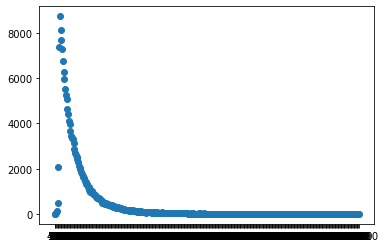

In [33]:
plt_values =  valid_user_base_statics_df['click_times_count'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

10.0       6361
11.0       8682
12.0       7974
13.0       7563
14.0       7204
15.0       6648
16.0       6265
17.0       5880
18.0       5490
19.0       5312
20.0       4943
21.0       4578
22.0       4551
23.0       4151
24.0       3912
25.0       3752
26.0       3484
27.0       3343
28.0       3231
29.0       3197
30.0       2957
31.0       2683
32.0       2620
33.0       2585
34.0       2470
35.0       2320
36.0       2265
37.0       2103
38.0       1985
39.0       1899
40.0       1840
41.0       1735
42.0       1609
43.0       1636
44.0       1562
45.0       1472
46.0       1354
47.0       1322
48.0       1295
49.0       1269
50.0       1152
51.0       1139
52.0       1094
53.0        935
54.0        962
55.0        997
56.0        864
57.0        832
58.0        819
59.0        845
           ... 
430.0         2
432.0         1
438.0         1
441.0         2
449.0         1
450.0         1
452.0         1
453.0         1
461.0         2
462.0         2
467.0         1
474.0   

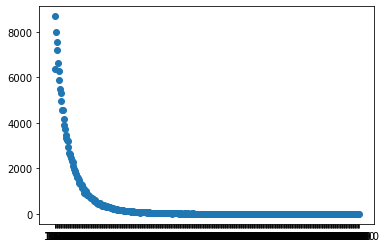

In [34]:
plt_values =  valid_user_base_statics_df['click_times_sum'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  2.0     2.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  1.0     2.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  1.0     1.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...                       ...                    ...               .

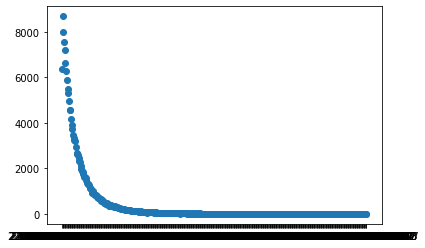

In [35]:
valid_user_base_statics_df['click_times_sum_log'] =  valid_user_base_statics_df['click_times_sum'].apply(lambda x: math.log(x))
print(valid_user_base_statics_df)
plt_values =  valid_user_base_statics_df['click_times_sum_log'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

In [36]:
print(valid_user_base_statics_df)

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  2.0     2.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  1.0     2.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  1.0     1.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...                       ...                    ...               .

In [37]:
false_user_df = ret_df[ret_df.predicted_age != ret_df.label_age ]
false_user_df = false_user_df.merge(user_base_statics_df,on='user_id')
print(false_user_df)

        user_id  predicted_age  label_age  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
0        720002              2          1             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  1.0     2.0             3.367296               3.367296
1        720005              1          4             24.0               24.0           23.0                 9.0                       5.0                   18.0              14.0  4.0     1.0             3.178054               3.178054
2        720007              1          3             18.0               16.0           15.0                10.0                       6.0                   13.0              11.0  3.0     1.0             2.890372               2.772589
...         ...            ...        ...           

4.0           3
5.0           3
6.0          19
7.0          95
8.0         328
9.0        1444
10.0       5103
11.0       6035
12.0       5601
13.0       5249
14.0       4949
15.0       4636
16.0       4254
17.0       3975
18.0       3772
19.0       3500
20.0       3348
21.0       3061
22.0       2913
23.0       2724
24.0       2653
25.0       2397
26.0       2252
27.0       2211
28.0       2183
29.0       2079
30.0       1892
31.0       1752
32.0       1725
33.0       1632
34.0       1561
35.0       1499
36.0       1378
37.0       1327
38.0       1250
39.0       1215
40.0       1162
41.0       1065
42.0       1028
43.0       1039
44.0        948
45.0        890
46.0        839
47.0        854
48.0        758
49.0        782
50.0        636
51.0        624
52.0        646
53.0        663
           ... 
362.0         1
364.0         1
365.0         1
366.0         1
368.0         1
369.0         1
370.0         1
372.0         1
375.0         2
376.0         1
384.0         2
388.0   

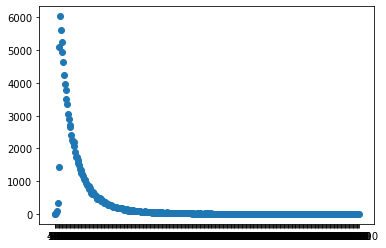

In [38]:
plt_values =  false_user_df['click_times_count'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()